# Implementing the fun filters from AA228 on my own!
1. Extended Kalman Filter
2. Unscented Kalman Filter
3. Particle Filter (not right now, but maybee in the future?)

With scenarios to generate data for the filters
   

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pprint import pprint
sys.path.append("../..")
from estimation.filtering.ekf import State, EkfParams, EKF

# from importlib import reload  # Python 3.4+



In [94]:
# State
example_state = State(1,np.diag([1,1,1]))
print(example_state)

State(x=1, P=array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]]))


# Scenarios

## AA272 (GPS Class) HW4

Order of stuff here
- Steup
  - State transition model
  - Measurement model
  - State transition covariance
  - Measurement covariance
- Data generation
  - Data validation (as per the HW notebook)

State
$$
\mu_t := \begin{bmatrix} x_{t} & y_{t} & \theta_t \end{bmatrix}^\top,
$$

Input
$$
u_t := \begin{bmatrix} v_t & \alpha_t \end{bmatrix}^\top
$$


### Setup

State transition
$$
\begin{aligned}
\mu_t &= f(\mu_{t-1}, u_{t}) + w_t, \\
&= \underbrace{\mu_{t-1} + \Delta t \begin{bmatrix} v_{t} \cos(\theta_{t-1}) \\ v_{t} \sin(\theta_{t-1}) \\ \alpha_{t} \end{bmatrix}}_{f(\mu_{t-1}, u_{t})} + w_t,
\end{aligned}
$$

In [95]:
def state_transition_model(dt: float, state, u):
    """
    Nominal state transition model
        Inputs:
            dt: timestep [float]
            state: current state (3,) [x, y, theta]
            u_cur: current control input (2,) [v, alpha]
        Outputs:
            mu_next: next state (3,) [x, y, theta]
    """
    _,_,theta = state
    v,alpha = u

    return state + dt * np.array(
        [v*np.cos(theta), v*np.sin(theta), alpha]
    )

def simulate_noisy_state_transition(dt, state, u, Q):
    """
    Simulate noisy state transition
    Inputs:
        dt: timestep [float]
        state: current state mean (3,) [x, y, theta]
        u: current control input (2,) [v, alpha]
        Q: process noise covariance (3x3)
    Outputs:
        state_next: next state mean (3x1) [v, alpha]
    """
    state_next = state_transition_model(dt, state, u) + np.random.multivariate_normal(np.zeros(3), Q)
    return state_next



Measurements

$$
h^{(i)}(\mu_t) = \sqrt{(x^{(i)} - x_t)^2 + (y^{(i)} - y_t)^2},
$$

In [96]:
def measurement_model(state):
    """
    Measurement model
        Inputs:
            state: current state mean (3,) [x, y, theta]
        Outputs:
            z: measurement vector (4,) [d_1, d_2, d_3, d_4]
    """
    # Absolute beacon positions
    posb = 120
    xy_beacon = np.array([[-posb, posb], [posb, posb], [posb, -posb], [-posb, -posb]])
    
    z = np.zeros(4)
    x,y,_ = state

    for i, b in enumerate(xy_beacon):
        xb,yb = b
        z[i] = np.sqrt( (x - xb)**2 + (y - yb)**2 )

    return z

# simulate noisy meas
def simulate_noisy_measurement(state, R):
    """
    Simulate noisy measurement
        Inputs:
        state: current state mean (3,) [x, y, theta]
        R: measurement noise covariance (4x4)
        Outputs:
            z_meas: measurement vector (4,) [d_1, d_2, d_3, d_4]
    """
    z_meas = measurement_model(state) + np.random.multivariate_normal(np.zeros(4), R)
    return z_meas

State transition and Measurement covariances
$$
\begin{aligned}
F(\mu_t, u_t) &= \begin{bmatrix} 1 & 0 & -\Delta t\ v_t sin(\theta_{t-1}) \\
    0 & 1 & \Delta t\ v_t cos(\theta_{t-1}) \\
    0 & 0 & 1 \end{bmatrix}
\end{aligned}
$$

$$
\begin{aligned}
H_t &= \begin{bmatrix}
\frac{2(x^1 - x_t)(-1)}{2 \sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
\frac{2(y^1 - y_t)(-1)}{2 \sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
0 \\
& \vdots & \\
\frac{2(x^4 - x_t)(-1)}{2 \sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
\frac{2(y^4 - y_t)(-1)}{2 \sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
0 \\
\end{bmatrix} \\ \\
&= \begin{bmatrix}
\frac{-(x^1 - x_t)}{\sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
\frac{-(y^1 - y_t)}{\sqrt{(x^1 - x_t)^2 + (y^1 - y_t)^2}} &
0 \\
& \vdots & \\
\frac{-(x^4 - x_t)}{\sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
\frac{-(y^4 - y_t)}{\sqrt{(x^4 - x_t)^2 + (y^4 - y_t)^2}} &
0 \\
\end{bmatrix} \\
\end{aligned}
$$

In [103]:
def get_F(dt, state, u):
    """
    Compute the Jacobian of the state transition model
    Inputs:
        dt: timestep [float]
        state: current state mean (3,) [x, y, theta]
        u: current control input (2,) [v, alpha]
    Outputs:
        F: Jacobian matrix (3x3)
    """
    _,_,theta = state
    v,_ = u
    F = np.array([
      [1, 0, -dt * v * np.sin(theta)],
      [0, 1, dt * v * np.cos(theta)],
      [0, 0, 1]
    ])

    return F

def get_H(state):
    """
    Compute the Jacobian of the measurement model
    Inputs:
        state: current state mean (3,) [s_t, alpha, theta]
    Outputs:
        H: Jacobian matrix (4x3)
    """

    x,y,_  = state
    H = np.zeros((4,3))


    # distances from beacons
    xy_beacon = np.array([[-120, 120], [120, 120], [120, -120], [-120, -120]])

    # Did this the long way at first
    d1 = np.sqrt((x - xy_beacon[0][0])**2 + (y - xy_beacon[0][1])**2)
    d2 = np.sqrt((x - xy_beacon[1][0])**2 + (y - xy_beacon[1][1])**2)
    d3 = np.sqrt((x - xy_beacon[2][0])**2 + (y - xy_beacon[2][1])**2)
    d4 = np.sqrt((x - xy_beacon[3][0])**2 + (y - xy_beacon[3][1])**2)


    H = np.array([
        [(x - xy_beacon[0][0]) / d1, (y - xy_beacon[0][1]) / d1, 0],
        [(x - xy_beacon[1][0]) / d2, (y - xy_beacon[1][1]) / d2, 0],
        [(x - xy_beacon[2][0]) / d3, (y - xy_beacon[2][1]) / d3, 0],
        [(x - xy_beacon[3][0]) / d4, (y - xy_beacon[3][1]) / d4, 0],
    ])

    x_dist = x - xy_beacon[:,0]
    y_dist = y - xy_beacon[:,1]
    distances = np.sqrt(
        x_dist**2 + y_dist**2
    )

    H = np.vstack(
        ((x_dist / distances), (y_dist / distances), np.zeros(4))
    ).T

    return H

In [146]:
# Testing state covariances
dt = 1
# *** DO NOT MODIFY THE CODE BELOW ***
# For test (do not modify)
mu_test1 = np.array([10, 30, np.pi/4])
u_test1 = np.array([5, 0.1])
F_test1 = get_F(dt, mu_test1, u_test1)

mu_test2 = np.array([20, -10, np.pi/6])
u_test2 = np.array([3, -0.2])
F_test2 = get_F(dt, mu_test2, u_test2)

# for autograder
sol_35 = np.hstack([F_test1.flatten(), F_test2.flatten()])
print("State Transition Covariance Test\n   Result:", *np.round(sol_35, 2))
print("Should be: 1.0 0.0 -3.54 0.0 1.0 3.54 0.0 0.0 1.0 1.0 0.0 -1.5 0.0 1.0 2.6 0.0 0.0 1.0\n")

mu_test1 = np.array([10, 30, np.pi/4])
H_test1 = get_H(mu_test1)
mu_test2 = np.array([20, -10, np.pi/6])
H_test2 = get_H(mu_test2)
# for autograder
sol_36 = np.hstack([H_test1.flatten(), H_test2.flatten()])

print("Measurement Covariance Test\n   Result:", *np.round(sol_36, 2))
print("Should be: 0.82 -0.57 0.0 -0.77 -0.63 0.0 -0.59 0.81 0.0 0.65 0.76 0.0 0.73 -0.68 0.0 -0.61 -0.79 0.0 -0.67 0.74 0.0 0.79 0.62 0.0")

State Transition Covariance Test
   Result: 1.0 0.0 -3.54 0.0 1.0 3.54 0.0 0.0 1.0 1.0 0.0 -1.5 0.0 1.0 2.6 0.0 0.0 1.0
Should be: 1.0 0.0 -3.54 0.0 1.0 3.54 0.0 0.0 1.0 1.0 0.0 -1.5 0.0 1.0 2.6 0.0 0.0 1.0

Measurement Covariance Test
   Result: 0.82 -0.57 0.0 -0.77 -0.63 0.0 -0.59 0.81 0.0 0.65 0.76 0.0 0.73 -0.68 0.0 -0.61 -0.79 0.0 -0.67 0.74 0.0 0.79 0.62 0.0
Should be: 0.82 -0.57 0.0 -0.77 -0.63 0.0 -0.59 0.81 0.0 0.65 0.76 0.0 0.73 -0.68 0.0 -0.61 -0.79 0.0 -0.67 0.74 0.0 0.79 0.62 0.0


### Data Generation

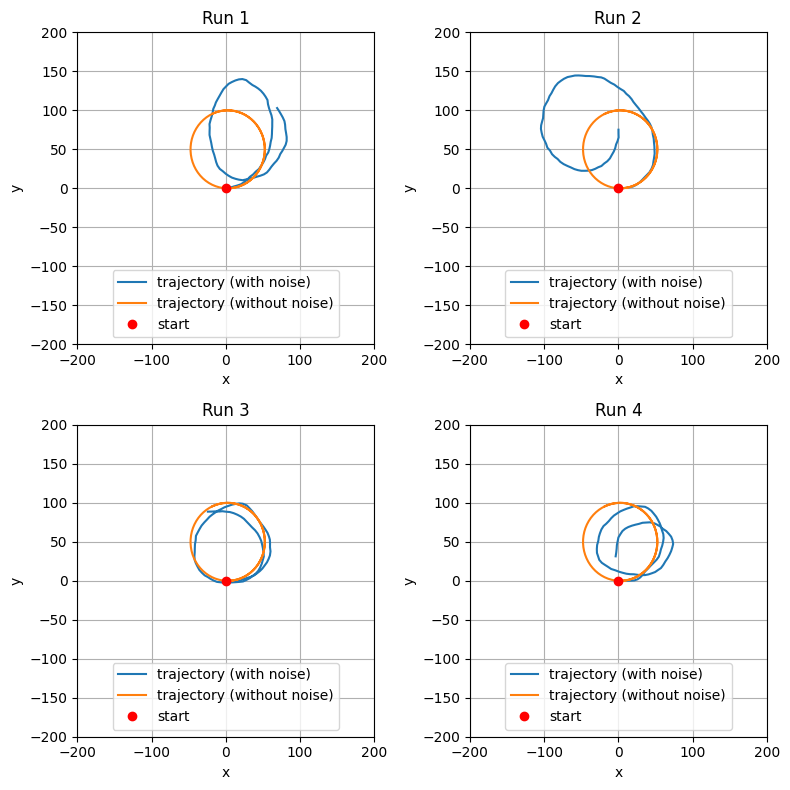

In [98]:
# Scenario from the AA272 (GPS) HW4 where 

def setup_gps_environment(
    delta_t: float = 1,  # time step
    Q = np.diag(np.array([0.1, 0.1, 0.01])),  # process noise covariance
    R = 10 * np.eye(4),  # measurement noise covariance
    seed = 0,  # random seed for reproducibility (do not change!!!)
    lent = 100,  # length of trajectory
    n_mc = 4,  # number of Monte Carlo simulations
    x0 = np.array([0, 0, 0])  # initial state [v_0, alpha, theta]
):
    # control input
    st = 5   # speed
    alpha = 0.1  # angular rate
    u_cur = np.array([st, alpha]) # current control input (2x1) [v_t, alpha]

    # set random seed
    np.random.seed(seed)

    env = {
        'delta_t': delta_t,
        'Q': Q,
        'R': R,
        'lent': lent,
        'n_mc': n_mc,
        'x0': x0,
        'u_cur': u_cur,
        'seed': seed
    }

    return env

# generate trajectories
def simulate_trajectories(env):
    """
    Simulate multiple trajectories with and without noise
    Outputs:
        X_true: true trajectory with noise (3 x lent x n_mc)
        X_nonoise: trajectory without noise (3 x lent)
    """
    lent = env['lent']
    n_mc = env['n_mc']
    u_cur = env['u_cur']
    Q = env['Q']
    x0 = env['x0']
    seed = env['seed']
    delta_t = env['delta_t']

    np.random.seed(seed)

    X_true = np.zeros((3, lent, n_mc))      # true trajectory with noise
    X_nonoise = np.zeros((3, lent))          # trajectory without noise

    # simulate no-noise trajectory
    for i in range(1, lent):
        X_curr = X_nonoise[:, i - 1]
        X_next = state_transition_model(delta_t, X_curr, u_cur)
        X_nonoise[:, i] = X_next

    # simulate noisy trajectory
    for mci in range(4):
        X_true[:, 0, mci] = x0

        for i in range(1, lent):
            X_curr = X_true[:, i - 1, mci]
            X_next = simulate_noisy_state_transition(delta_t, X_curr, u_cur, Q)
            X_true[:, i, mci] = X_next


    return X_true, X_nonoise


def plot_trajectories(X_true, X_nonoise, n_mc):
    """
    Plot the simulated trajectories
    Inputs:
        X_true: true trajectory with noise (3 x lent x n_mc)
        X_nonoise: trajectory without noise (3 x lent)
        n_mc: number of Monte Carlo simulations
    Outputs:
        None
    """

    plt.subplots(2, 2, figsize=(8,8))

    for mci in range(n_mc):
        # plot the trajectory
        plt.subplot(2, 2, mci + 1)
        plt.plot(X_true[0, :, mci], X_true[1, :, mci], label='trajectory (with noise)')
        plt.plot(X_nonoise[0, :], X_nonoise[1, :], label='trajectory (without noise)')
        plt.plot(X_true[0, 0, mci], X_true[1, 0, mci], 'ro', label='start')
        plt.title('Run ' + str(mci + 1))
        plt.xlabel('x')
        plt.ylabel('y')
        # plt.axis('equal')
        plt.grid(True)
        plt.xlim([-200, 200])
        plt.ylim([-200, 200])
        plt.legend(loc='lower center')

    plt.tight_layout()
    plt.show()

# simulate and plot trajectories
env = setup_gps_environment()
X_true, X_nonoise = simulate_trajectories(env)
plot_trajectories(X_true, X_nonoise, env['n_mc'])

Should look like this: 

![image info](./images/gps_traj_success.png)

{'delta_t': 1, 'Q': array([[0.1 , 0.  , 0.  ],
       [0.  , 0.1 , 0.  ],
       [0.  , 0.  , 0.01]]), 'R': array([[10.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.],
       [ 0.,  0., 10.,  0.],
       [ 0.,  0.,  0., 10.]]), 'lent': 100, 'n_mc': 4, 'x0': array([0, 0, 0]), 'u_cur': array([5. , 0.1]), 'seed': 0}


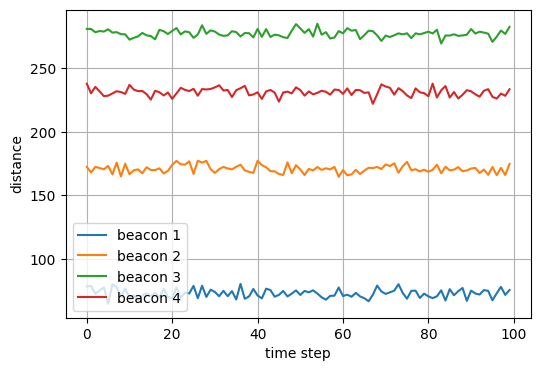

In [99]:
def simulate_measurements(pos, R, sim_num, seed=0):
   sim_num = 100
   z = np.zeros((4, sim_num))
   np.random.seed(seed)

   for i in range(sim_num):
      z[:, i] = simulate_noisy_measurement(pos, R)

   return z

# plot the four measurements
def plot_measurements(z):
   sim_num = z.shape[1]
   plt.subplots(1, 1, figsize=(6, 4))
   plt.plot(np.arange(sim_num), z[0, :], label='beacon 1')
   plt.plot(np.arange(sim_num), z[1, :], label='beacon 2')
   plt.plot(np.arange(sim_num), z[2, :], label='beacon 3')
   plt.plot(np.arange(sim_num), z[3, :], label='beacon 4')
   plt.xlabel('time step')
   plt.ylabel('distance')
   plt.grid(True)
   plt.legend()
   plt.show()

# simulate noisy meas
pos = np.array([-50, 100, 0])
z = simulate_measurements(pos, env['R'], sim_num=100)
print(env)
plot_measurements(z)

### EKF Design